In [1]:
# PERFORMANCE

import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import numpy as np
import sys
import os

sys.path.insert(0, "../lib")
from utils import set_device, collate
from laplacian import normalized_laplacian

# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

%load_ext autoreload
%autoreload 2

cuda not available


In [2]:
# Downloads the dataset if not found locally
from dataset import check_mnist_dataset_exists, datasampler, MNISTDataset, MNIST_rand
_ = check_mnist_dataset_exists()

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data=640, nb_selected_test_data=640
)

#testset = MNISTDataset(test_data, test_labels)

In [3]:
from model import Classifier
# Using the 4-neighbors trained model

net = Classifier(
    1, 32, 50, 512, 10, 10
)

print(net)
if torch.cuda.is_available():
    net.to(device)
    
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Trained_Cheb'))

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


<All keys matched successfully>

In [4]:
import sklearn
from sklearn.metrics import classification_report


def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        L = normalized_laplacian(bg)
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, L), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()), 0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

    
    return (test_Y == argmax_Y.cpu().float()).sum().item() / len(test_Y) * 100
    
    
    #return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4, output_dict=True)

In [5]:
repz = []
evalrange = range(0, 10, 5)

In [6]:
for i in evalrange:
    report = []
    print(i, '%')
    for j in range(1):
        testset = MNIST_rand(test_data, test_labels, removal_rate = i/100, rand = False)

        # Define a test function
        data_loader_test = DataLoader(testset, batch_size=128,
                                      shuffle=False, collate_fn=collate)

        report.append(test_func(data_loader_test))
        #print(report[-1])
    repz.append(report)

0 %


RuntimeError: Expected object of scalar type Int but got scalar type Float for argument #2 'other'

In [38]:
testset = MNIST_rand(test_data, test_labels, removal_rate = 0)

In [ ]:
import pandas as pd
df = pd.DataFrame(repz)

df['mean'] = df.mean(1)
df['std'] = df.std(1)
print(df)
#df.to_pickle('./edge_removal')

In [8]:
import pandas as pd
df = pd.DataFrame
df = pd.read_pickle('./edge_removal')

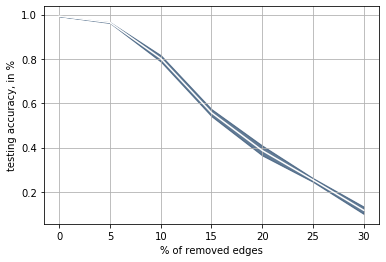

In [11]:
plt.plot(evalrange, df['mean'], color='white')
plt.fill_between(evalrange, df['mean'] - df['std'],
                 df['mean'] + df['std'], color="#3F5D7DD0")
#plt.title('Accuracy over number of removed edges')
plt.xlabel('% of removed edges')
plt.ylabel('testing accuracy, in %')
plt.grid()
plt.savefig('../../Master-Thesis/img/accuracyovernumberofremovededges.pdf')